In [264]:
import numpy as np
print("NumPy:", np.__version__)


NumPy: 2.3.2


In [265]:
import sys, os
from pathlib import Path

def attach_src_and_cd():
    here = Path.cwd()
    # Busca 'src' en la carpeta actual y en todos los padres
    for base in [here] + list(here.parents):
        cand = base / "src"
        if cand.is_dir():
            if str(cand) not in sys.path:
                sys.path.append(str(cand))
            # Pon el directorio de trabajo en la raíz del repo (donde vive 'src')
            os.chdir(base)
            print("OK: usando src en", cand)
            print("CWD ahora es:", Path.cwd())
            return True
    print("ERROR: no encontré carpeta 'src' empezando desde", here)
    return False

attach_src_and_cd()


OK: usando src en C:\Users\henry\economia-no-euclideana\src
CWD ahora es: C:\Users\henry\economia-no-euclideana


True

## Paso 1: Generamos los puntos sobre una superficie conocida

In [266]:
from src.data.synth import generate_sphere_points

N = 600

X = generate_sphere_points(N)
print("Shape de X:", X.shape)
print("Primeros 5 puntos:\n", X[:5])




Shape de X: (600, 3)
Primeros 5 puntos:
 [[-0.54027137  0.81592077  0.20586439]
 [-0.62568936 -0.73125415 -0.2716251 ]
 [ 0.9884522   0.07927761  0.12914069]
 [ 0.06551114 -0.78397305 -0.61732856]
 [-0.80926638  0.46894049  0.35381172]]


# Sanity Check

In [267]:
import numpy as np

r = np.linalg.norm(X, axis=1)
print("radio medio:", r.mean(), "  desvío:", r.std(), "  min/max:", r.min(), r.max())


radio medio: 1.0   desvío: 5.438959822042073e-17   min/max: 0.9999999999999998 1.0000000000000002


# Vizuals
Ya tenemos nuestra esfera. Vamos a verla!

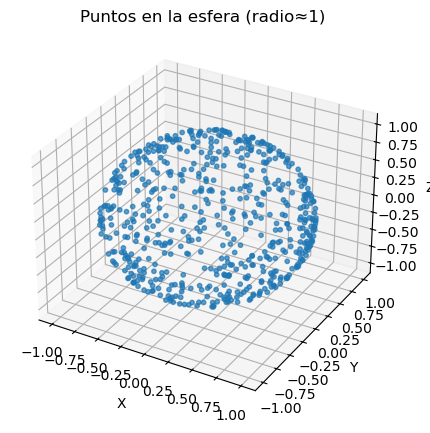

In [268]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # activa 3D

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:,0], X[:,1], X[:,2], s=10, alpha=0.7)

ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Puntos en la esfera (radio≈1)")
plt.show()


# OPCIONAL RUIDOOOOOOOO

In [6]:
from src.data.synth import add_gaussian_noise 

X_noisy = add_gaussian_noise(X, std=0.02, seed=42)  # ruido un poco visible


In [7]:
r_clean = np.linalg.norm(X, axis=1)      # radios ~ 1.000
r_noisy = np.linalg.norm(X_noisy, axis=1)  # radios ~ 0.95–1.05 (aprox)
r_clean[:5], r_noisy[:5]


(array([1., 1., 1., 1., 1.]),
 array([1.00326841, 1.00184006, 0.96428083, 0.99191141, 1.04335197]))

# KNN

Conectaremos cada punto con su K vecinos mas cercanos

In [269]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, csgraph
import matplotlib.pyplot as plt


In [270]:

from src.graph.knn import build_knn_graph 

k = 20
G = build_knn_graph(X, k)

# 3) Revisa que funcione
print(G)
print("Nodos:", G.number_of_nodes())
print("Aristas:", G.number_of_edges())



Graph with 600 nodes and 6523 edges
Nodos: 600
Aristas: 6523


Si:
k es muy bajo → analizas la variedad a escalas muy finas.
k es muy alto → analizas la variedad a escalas más gruesas (más “promediadas”).

# Vizual KNN

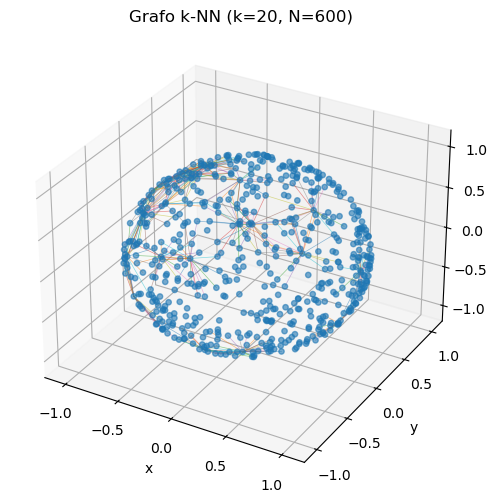

In [271]:
from src.viz.plots import plot_knn_graph_3d

plot_knn_graph_3d(
    X,
    G,
    max_edges=500,                  # aumenta/reduce según saturación
    outpath="artifacts/knn_3d.png", # opcional, guarda imagen
    title=f"Grafo k-NN (k={k}, N={N})"
)


# Geodesics

In [272]:

from __future__ import annotations
import numpy as np
import networkx as nx


In [273]:
from src.geodesic.shortest_paths import compute_geodesic_distances, handle_disconnections, is_symmetric, has_zero_diagonal


In [274]:
# Calculamos distancias geodesicas

In [275]:
D = compute_geodesic_distances(G)
print("Matriz de distancias geodésicas:", D.shape)


Matriz de distancias geodésicas: (600, 600)


In [276]:
from src.geodesic.shortest_path_FAST import compute_geodesic_distances_fast

# Dijkstra (rápido)
%time D= compute_geodesic_distances_fast(G, method="D")

# (Opcional) si quieres comparar con tu versión vieja:
# %time D_fw = nx.floyd_warshall_numpy(G, weight="weight")


CPU times: total: 750 ms
Wall time: 898 ms


In [277]:
# Manejamos desconexiones

In [278]:
D = handle_disconnections(D, strategy="big_value")


In [279]:
# sanity checks

In [280]:
print("¿Simétrica?", is_symmetric(D))
print("¿Diagonal cero?", has_zero_diagonal(D))


¿Simétrica? True
¿Diagonal cero? True


In [281]:
# Ejemplo

In [282]:
print("Distancia entre nodo 0 y 1:", D[19,310])


Distancia entre nodo 0 y 1: 0.11001678856665258


In [283]:
# Viz Geodesica

In [284]:
from src.viz.plots import plot_geodesic_path_3d

In [285]:
src, dst = 0, 470

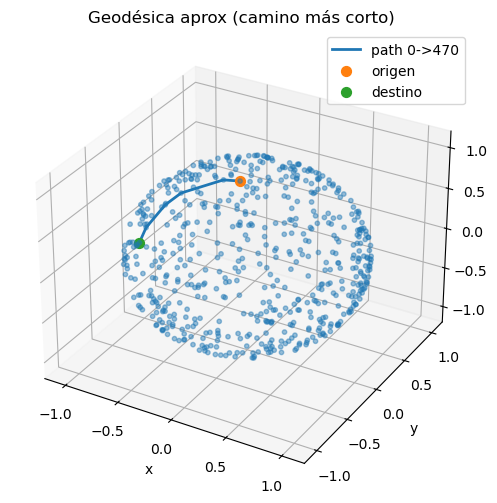

In [286]:
plot_geodesic_path_3d(
    X, G, src, dst,
    outpath="artifacts/geodesic_path.png"
)

In [287]:
# contrastemos!

In [288]:
from src.viz.plots import plot_geodesic_vs_euclidean

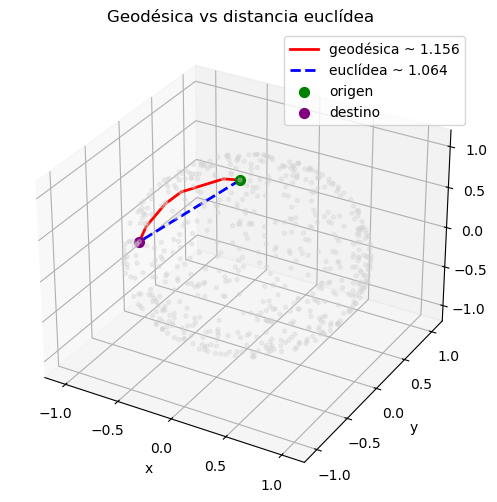

In [289]:
plot_geodesic_vs_euclidean(X, G, src, dst, outpath="artifacts/geodesic_vs_euclidean.png")

In [290]:
#Heatmap


In [291]:
from src.viz.plots import plot_geodesic_distance_matrix


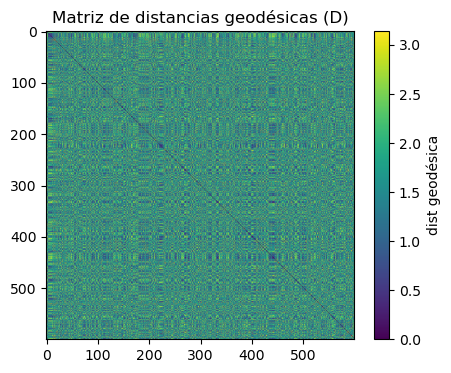

In [292]:
plot_geodesic_distance_matrix(
    D
)

In [293]:
#MDS

In [294]:
from src.embed.isomap import classical_mds


In [295]:








#Embeding en 2D

In [296]:
Y2 = classical_mds(D, n_components=2)
print("Shape embedding 2D:", Y2.shape)


Shape embedding 2D: (600, 2)


In [297]:
# Embeding en 3D

In [298]:
# Embedding en 3D
Y3 = classical_mds(D, n_components=3)
print("Shape embedding 3D:", Y3.shape)

Shape embedding 3D: (600, 3)


In [299]:
# Viz 2D

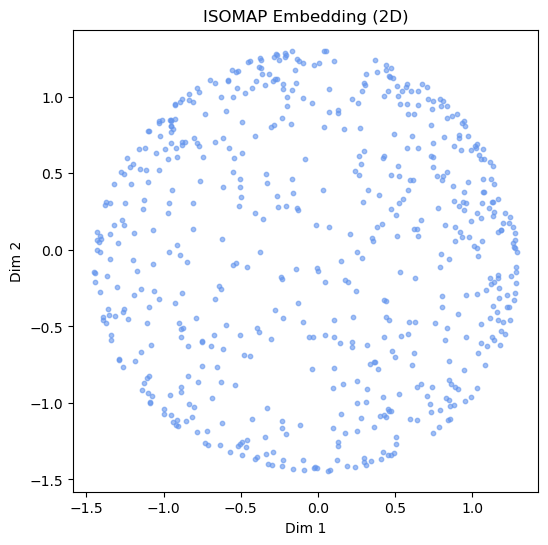

In [300]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(Y2[:,0], Y2[:,1], s=10, alpha=0.6, c="cornflowerblue")
plt.title("ISOMAP Embedding (2D)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.show()


In [301]:
#Viz 3D

In [302]:
#Sanity Check

In [303]:
# Checar media ~ 0 (centrado)
print("Media de cada columna:", Y2.mean(axis=0))

# Ver primeras distancias preservadas
import numpy as np
print("Dist original (0,1):", D[0,1])
print("Dist embebida (0,1):", np.linalg.norm(Y2[0]-Y2[1]))


Media de cada columna: [-2.59052039e-18 -8.78926561e-19]
Dist original (0,1): 1.9021281276261643
Dist embebida (0,1): 1.4277913260097426


In [304]:
# ESTO YA ES ISOMAP COMPLETOOOOO

In [305]:
# Etiquetemos los puntos para ver en donde se ubican

In [306]:
n = X.shape[0]
ids = np.arange(n)  # 0..n-1


In [307]:
# Ejemplo: 25 al azar (reproducible)
np.random.seed(123)
idx_to_label = np.random.choice(n, size=25, replace=False)

# O fija tú los que quieras:
# idx_to_label = np.array([0, 5, 42, 123, 199])


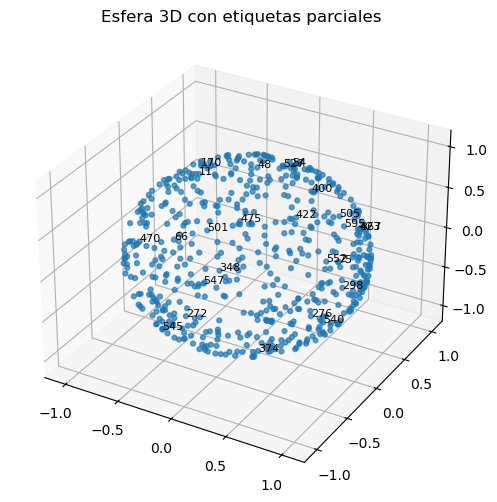

In [308]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X[:,0], X[:,1], X[:,2], s=12, alpha=0.7)

# Etiquetas (solo la muestra)
for i in idx_to_label:
    ax.text(X[i,0], X[i,1], X[i,2], str(i), fontsize=8)

for a in (ax.set_xlim, ax.set_ylim, ax.set_zlim):
    a([-1.2, 1.2])

ax.set_title("Esfera 3D con etiquetas parciales")
plt.savefig("artifacts/fig_sphere_labels.png", dpi=300, bbox_inches="tight")
plt.show()


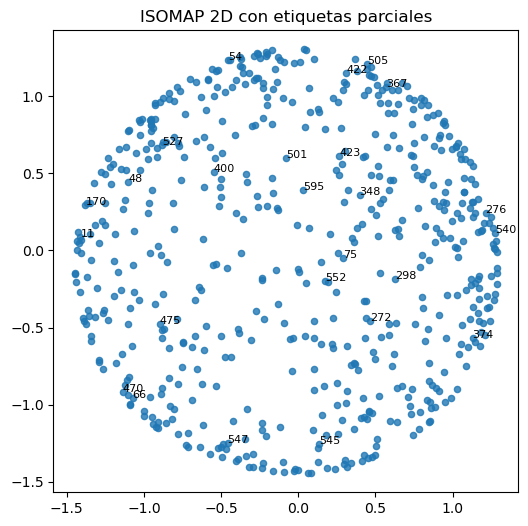

In [309]:
plt.figure(figsize=(6,6))
plt.scatter(Y2[:,0], Y2[:,1], s=20, alpha=0.8)

for i in idx_to_label:
    plt.text(Y2[i,0], Y2[i,1], str(i), fontsize=8)

plt.axis("equal")
plt.title("ISOMAP 2D con etiquetas parciales")
plt.savefig("artifacts/fig_isomap2d_labels.png", dpi=300, bbox_inches="tight")
plt.show()


In [310]:
# Coloreamos

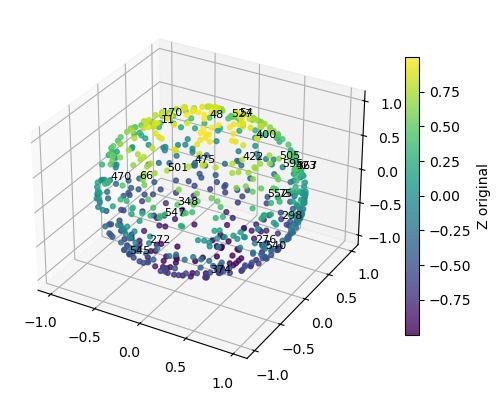

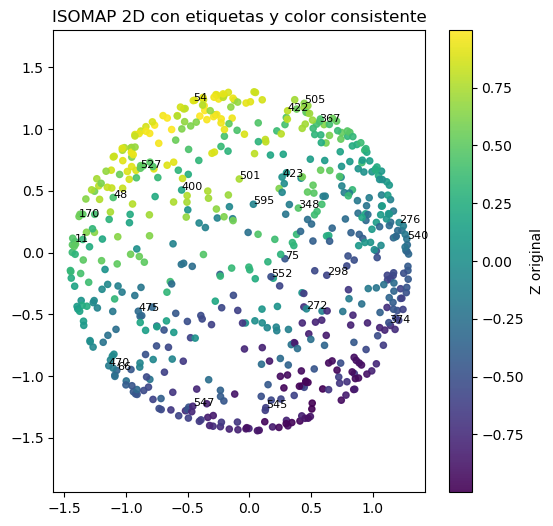

In [311]:
# Color por altura Z (del X "limpio", sin ruido, o del Xn)
c = X[:,2]  # o Xn[:,2]

# Esfera
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X[:,0], X[:,1], X[:,2], c=c, s=12, alpha=0.8)
fig.colorbar(sc, ax=ax, shrink=0.6, label="Z original")
for i in idx_to_label:
    ax.text(X[i,0], X[i,1], X[i,2], str(i), fontsize=8)
plt.savefig("artifacts/fig_sphere_labels_colored.png", dpi=300, bbox_inches="tight")
plt.show()

# ISOMAP 2D
plt.figure(figsize=(6,6))
plt.scatter(Y2[:,0], Y2[:,1], c=c, s=20, alpha=0.9)
for i in idx_to_label:
    plt.text(Y2[i,0], Y2[i,1], str(i), fontsize=8)
plt.axis("equal"); plt.colorbar(label="Z original")
plt.title("ISOMAP 2D con etiquetas y color consistente")
plt.savefig("artifacts/fig_isomap2d_labels_colored.png", dpi=300, bbox_inches="tight")
plt.show()


In [312]:
# TERMINAMOS ISOMAP PODEMOS AHORA INICIAR LA GEO DESCRIPTIVA

### LPCA (Local PCA) – Estimación de planos tangentes

La idea es que, en una variedad 2D inmersa en \(\mathbb{R}^3\), el vecindario de un punto se puede aproximar por un **plano tangente**.

**Procedimiento:**
1. Tomamos el punto central \(x_c\) y sus vecinos \(x_j\).
2. Centramos: \(P = X_{\text{vecinos}} - x_c\).
3. Hacemos **SVD**: \(P = U \Sigma V^\top\).
4. En \(\mathbb{R}^3\):  
   - Las **dos primeras columnas de \(V\)** forman la base del plano tangente (`E`, de tamaño (3,2)).  
   - La **última columna** es la aproximación al vector normal (`normal`, de tamaño (3,)).  
   - Los **valores singulares principales** (`svals`) indican la variabilidad local en cada dirección tangente.

**Ejemplo de salida:**
- `E.shape = (3,2)` → dos vectores base del plano tangente.  
- `normal.shape = (3,)` → vector normal ortogonal.  
- `svals = [1.29, 0.94]` → varianzas locales en las direcciones tangentes.


In [313]:
import numpy as np
import matplotlib.pyplot as plt


from src.geom.lpca import tangent_plane
from src.viz.plots import plot_tangent_frame_3d 

In [314]:
center_idx = 200                                 # el punto que quieras analizar
neighbors_idx = np.array(list(G.neighbors(center_idx)))

In [315]:
center, E, normal, svals = tangent_plane(X, neighbors_idx, center_idx, d=2)
print(E.shape, normal.shape if normal is not None else None, svals)


(3, 2) (3,) [1.10208707 0.82085182]


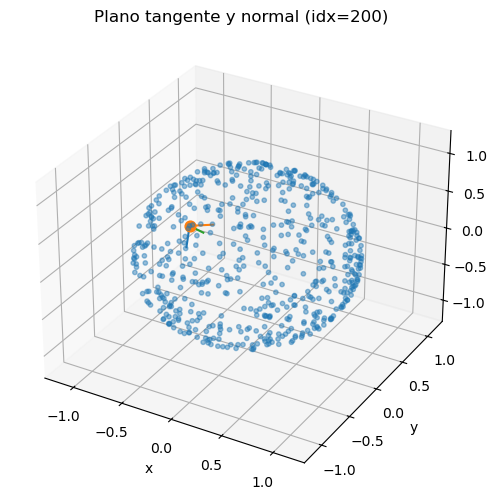

In [316]:
plot_tangent_frame_3d(
    X,                     # o X
    center_idx=center_idx,
    E=E,
    normal=normal,
    scale=0.25,
    outpath="artifacts/fig_tangent_center42.png",
    title=f"Plano tangente y normal (idx={center_idx})"
)


In [317]:
#Vecinos usados

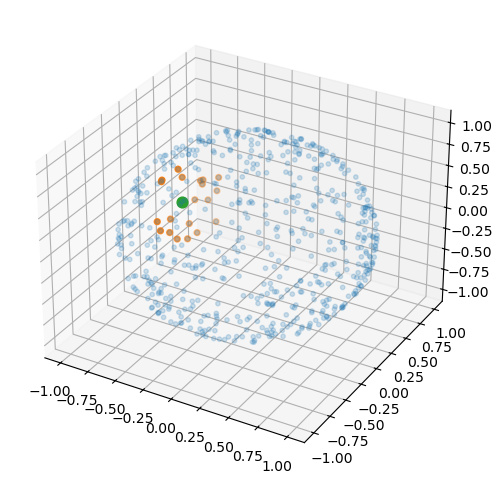

In [318]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")

# todos (suaves)
ax.scatter(X[:,0], X[:,1], X[:,2], s=10, alpha=0.2)

# vecinos resaltados
Nv = X[neighbors_idx]
ax.scatter(Nv[:,0], Nv[:,1], Nv[:,2], s=18)

# centro
c = X[center_idx]
ax.scatter([c[0]], [c[1]], [c[2]], s=60)

plt.savefig(f"artifacts/fig_neighbors_{center_idx}.png", dpi=300, bbox_inches="tight")
plt.show()


Coordenadas locales (LPCA → proyección):

In [319]:
from sklearn.decomposition import PCA

In [320]:
from src.geom.metric import local_coordinates
from src.viz.plots import plot_tangent_frame_3d

In [321]:
# Vecinos del punto y proyección al plano tangente
Nv = X[neighbors_idx]                         # (m, 3)
coords2 = local_coordinates(Nv, center=center, E=E)  # (m, 2)

# El propio centro en coords locales (debe ser ~ (0,0))
c_local = local_coordinates(center[None, :], center=center, E=E)[0]
print("Centro en coords locales:", c_local)


Centro en coords locales: [0. 0.]


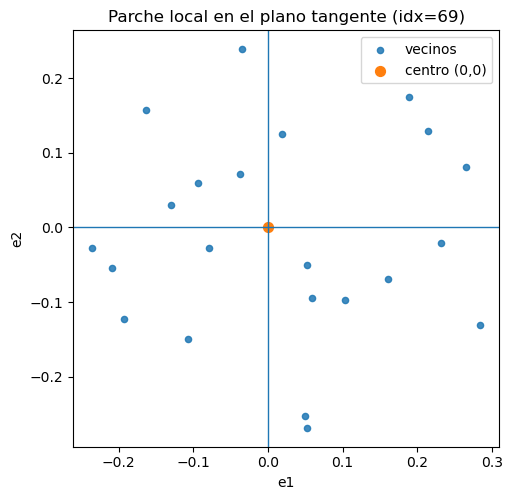

In [344]:
plt.figure(figsize=(5.5, 5.5))
plt.scatter(coords2[:,0], coords2[:,1], s=20, alpha=0.85, label="vecinos")
plt.scatter([c_local[0]], [c_local[1]], s=50, label="centro (0,0)")
plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
plt.gca().set_aspect("equal", adjustable="box")
plt.title(f"Parche local en el plano tangente (idx={center_idx})")
plt.xlabel("e1"); plt.ylabel("e2"); plt.legend()
plt.savefig(f"artifacts/fig_local_patch_{center_idx}.png", dpi=300, bbox_inches="tight")
plt.show()


In [345]:
pca2 = PCA(n_components=2).fit(coords2)
print("Varianzas locales (patch 2D):", pca2.explained_variance_)

# razón entre la primera y la segunda varianza
ratio = pca2.explained_variance_[0] / pca2.explained_variance_[1]
print("Razón de anisotropía (var1/var2):", ratio)


Varianzas locales (patch 2D): [0.02554094 0.01795298]
Razón de anisotropía (var1/var2): 1.4226572592221454


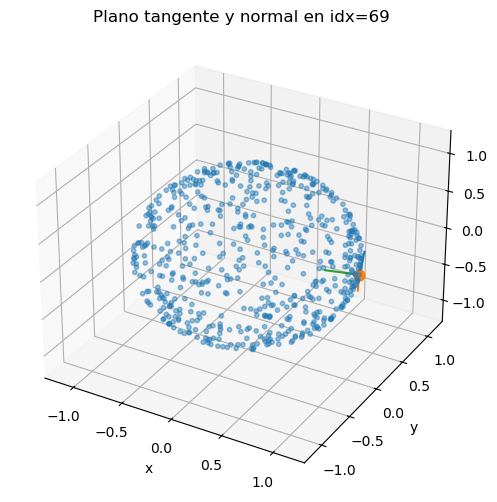

In [346]:
plot_tangent_frame_3d(
    X,
    center_idx=center_idx,
    E=E,
    normal=normal,
    scale=0.3,
    outpath=f"artifacts/fig_tangent_frame_{center_idx}.png",
    title=f"Plano tangente y normal en idx={center_idx}"
)


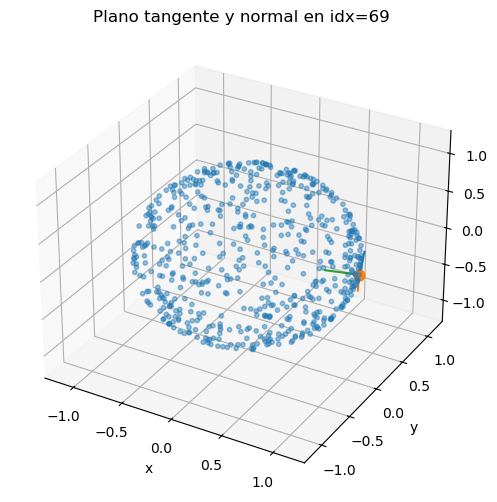

In [347]:
plot_tangent_frame_3d(
    X, center_idx, E, normal,
    scale=0.3,
    outpath=f"artifacts/fig_tangent_frame_{center_idx}.png",
    title=f"Plano tangente y normal en idx={center_idx}"
)


In [326]:
#Métrica local en el parche (estimate_metric).

In [327]:
from src.geom.metric import local_coordinates, estimate_metric
from src.viz.plots import plot_local_patch_with_ellipse

In [328]:
# 1) Parche local en coords (ya tienes center, E, neighbors_idx, Xn)
Nv = X[neighbors_idx]                         # (m, 3)
coords2 = local_coordinates(Nv, center=center, E=E)  # (m, 2)


In [330]:
# 2) Estimar métrica (normalizada, trace ≈ 2)
g = estimate_metric(coords2, weighted=False)
print("g:\n", g)
print("trace(g) =", np.trace(g))


g:
 [[ 1.28638002e+00 -1.24932847e-16]
 [-1.24932847e-16  7.13619981e-01]]
trace(g) = 2.0


In [331]:
# 3) Diagnóstico rápido: autovalores (anisotropía) y razón
evals, _ = np.linalg.eigh(g)
evals = np.sort(evals)[::-1]  # mayor → menor
print("eigenvals(g) =", evals)
print("razón mayor/menor =", evals[0] / evals[-1])


eigenvals(g) = [1.28638002 0.71361998]
razón mayor/menor = 1.8026121107020148


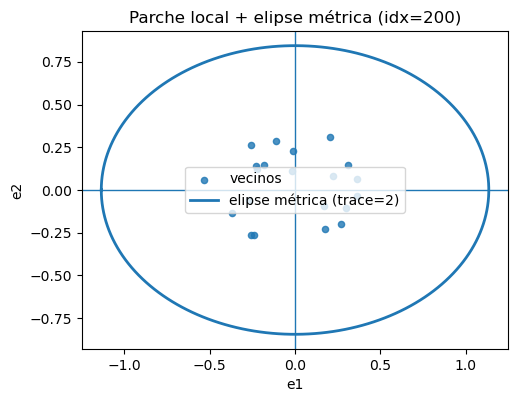

In [332]:
# 4) Visual del parche + elipse métrica
plot_local_patch_with_ellipse(
    coords2,
    g,
    outpath=f"artifacts/fig_local_metric_{center_idx}.png",
    title=f'Parche local + elipse métrica (idx={center_idx})'
)


In [333]:
for center_idx in [5, 100, 101, 69]:
    neighbors_idx = np.array(list(G.neighbors(center_idx)))
    center, E, normal, svals = tangent_plane(X, neighbors_idx, center_idx, d=2)
    coords2 = local_coordinates(X[neighbors_idx], center=center, E=E)
    g = estimate_metric(coords2, weighted=True)

    evals, evecs = np.linalg.eigh(g)              # evals ascendente
    lmin, lmax = float(evals[0]), float(evals[1])
    kappa = lmax / lmin
    tr = lmin + lmax

    print(f"{center_idx} → autovalores g: [{lmin:.4f} {lmax:.4f}]  "
          f"razón(lmax/lmin): {kappa:.2f}  trace: {tr:.4f}")


5 → autovalores g: [0.7846 1.2154]  razón(lmax/lmin): 1.55  trace: 2.0000
100 → autovalores g: [0.8711 1.1289]  razón(lmax/lmin): 1.30  trace: 2.0000
101 → autovalores g: [0.8911 1.1089]  razón(lmax/lmin): 1.24  trace: 2.0000
69 → autovalores g: [0.8311 1.1689]  razón(lmax/lmin): 1.41  trace: 2.0000


In [334]:
# POdemos ver que el punto 3 genero un mucho mejor parche

In [335]:
# Que pasa si parchamos usando geodesicas y no euclideas? NO es esto contraintuitivo? No perdemos localidad?

In [336]:
#ULTIMO ANAL. A PARTIR DE LA METRICA ESTIMADA

In [337]:
### Curvatura local vía parche cuadrático (Monge + mínimos cuadrados)


In [338]:
from src.geom.curvature_extrinsic import fit_quadratic_patch, curvature_from_quadratic

In [339]:
# 1) Marco tangente en el punto
center, E, normal, _ = tangent_plane(X, neighbors_idx, center_idx, d=2)


In [340]:
# 2) Parche local (coords 2D en el plano tangente)
Nv = X[neighbors_idx]                              # vecinos en 3D
coords2 = local_coordinates(Nv, center=center, E=E) # (m,2)

In [341]:
# 3) Alturas respecto a la normal (para el ajuste h(u,v))
heights = (Nv - center) @ normal                    # (m,)


In [342]:
# 4) Ajuste cuadrático y curvaturas
coeffs = fit_quadratic_patch(coords2, heights, weighted=True)
k1, k2, K, H, R = curvature_from_quadratic(coeffs)

In [343]:
print("Coeficientes [a, b, c, α, β, γ]:", coeffs)
print("Curvaturas principales:", k1, k2)
print("Curvatura gaussiana K:", K)
print("Curvatura media H:", H)
print("Curvatura escalar R=2K:", R)

Coeficientes [a, b, c, α, β, γ]: [ 1.02069308e+00 -1.53391989e-03  1.02007880e+00 -4.77260134e-02
  2.66984398e-02 -9.08873817e-05]
Curvaturas principales: 1.0188215728728605 1.0219503089017903
Curvatura gaussiana K: 1.0411850211132276
Curvatura media H: 1.0203859408873255
Curvatura escalar R=2K: 2.0823700422264553


In [100]:
#Sanity check

In [101]:
# K y H esperados (esfera unidad, ver teoría abajo sobre signos)
tol = 0.3
print("Esperado esfera: K≈1  | H≈±1 (según orientación de la normal)")

# sanity: magnitudes
assert np.isfinite([k1,k2,K,H,R]).all(), "Aparecieron NaN/Inf en curvaturas"

Esperado esfera: K≈1  | H≈±1 (según orientación de la normal)


In [103]:
from src.eval.curvature import analyze_center

# Ejemplo: esfera unidad con datos Xn y grafo G
_ = analyze_center(center_idx=42, X=X, G=G, weighted=True, radius=1.0, echo=True)


=== Análisis del ajuste cuadrático (parche local) ===
Coeficientes [a, b, c, α, β, γ]: [1.003714, -0.000010, 1.004159, -0.007430, -0.042772, -0.000002]
Orientación inferida por H: normal interior (espera k1,k2≈+1, H≈+1)

Curvaturas principales: k1=1.003714  (err +0.37%) | k2=1.004159  (err +0.42%)
  • Desbalance |k1-k2| = 0.000444   |   razón anisotropía (max/min) = 1.000
Curvatura gaussiana  K = 1.007888   (vs 1.0, err +0.79%)
Curvatura media      H = 1.003937   (vs +1.0, err +0.39%)
Curvatura escalar    R = 2.015777   (vs 2.0, err +0.79%)

Diagnóstico de términos del polinomio:
  • a≈1.0037, c≈1.0042; b≈-9.7490e-06 (cruzado pequeño deseable; relativo=9.71e-06)
  • Pendientes: α=-7.4298e-03, β=-4.2772e-02  (‖(α,β)‖=4.3412e-02)
  • Offset γ=-1.9034e-06

